This notebook is separated into two distinct sections: (1) obtaining GPT labels and (2) computing ATEs using GPT labels and generating plots. 
Feel free to proceed directly to the second section to execute the ATE calculations.

In [1]:
from utils import *
dataset = load_to_df("data/twitter_data.json")

data_df = dataset[(dataset["shown_to_user"]==True) & (dataset["timeline"].isin(["Engagement", "Chronological"]))]
print(f"Number of tweets in the data_df: {len(data_df.index)}")

100%|██████████| 1730/1730 [00:03<00:00, 519.17it/s]


Number of tweets in the data_df: 38790


In [2]:
ROW_KEYS = [
    "author_happy",
    "author_sad",
    "author_angry",
    "author_anxious",
    "is_political",
    "political_leaning",
    "political_outgroup_anger_left",
    "political_outgroup_anger_right",
]
GPT_KEYS = ["GPT_" + key for key in ROW_KEYS]
JSON_KEYS = [
    "happy",
    "sad",
    "angry",
    "anxious",
    "is_political",
    "political_leaning",
    "animosity_left",
    "animosity_right",
]

# Get GPT labels

In [2]:
from time import sleep
from tenacity import (
                    retry,
                    stop_after_attempt,
                    wait_random_exponential,
                    )
                    
from openai import OpenAI
client = OpenAI(api_key = "")

In [3]:
# remove duplicate tweets
tweets_df = data_df.drop_duplicates(subset=['id_str'])
print(f"Number of unique tweets: {len(tweets_df.index)}")

Number of unique tweets: 31609


In [4]:
with open("prompts/double.prompt") as f:
    double_prompt_template = f.read().rstrip("\n")
with open("prompts/single.prompt") as f:
    single_prompt_template = f.read().rstrip("\n")

def get_prompt_for_tweet(df, main_id):
    
    main_row = df[df["id_str"] == main_id].iloc[0, :]
    main_tweet_text = main_row["full_text"]
    author_main = main_row["display_name"]

    other_df = df[(df["main_tweet_id"] == main_id) & (df["tweet_type"] != "main_tweet")]
    assert len(other_df.index) <= 2

    prompts = []
    if len(other_df.index) >= 1:
        for _, row in other_df.iterrows():
            other_tweet_text = row["full_text"]
            author_other = row["display_name"]
            other_tweet_type = "quote tweet of" if row["tweet_type"] == "quoted_tweet" else "reply to"
            prompt = double_prompt_template.format(main_tweet_text=main_tweet_text, author_main=author_main, other_tweet_text=other_tweet_text, author_other=author_other, other_tweet_type=other_tweet_type)
            prompts.append(prompt)
    else:
        prompt = single_prompt_template.format(main_tweet_text=main_tweet_text, author_main=author_main)
        prompts.append(prompt)
    return prompts

In [5]:
main_ids = tweets_df["main_tweet_id"].unique()
print(f"Number of unique main_ids: {len(main_ids)}")
prompt_lst = [get_prompt_for_tweet(tweets_df, main_id) for main_id in main_ids]
# with open("prompts/prompts.json", "w") as f:
#     json.dump(prompt_lst, f)

with open("prompts/prompts.json", "r") as f:
    prompt_lst = json.loads(f.read())

Number of unique main_ids: 28301


In [46]:
@retry(wait=wait_random_exponential(min=1, max=30), stop=stop_after_attempt(1000))
def get_gpt_judgements(prompt, random_seed):
    completion = client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        response_format={"type": "json_object"},
        seed=random_seed
        )

    completion_json = json.loads(completion.choices[0].message.content.strip())
    return completion_json

In [ ]:
complete_json_lst = []
for prompts in tqdm.tqdm(prompt_lst):
    json_lst = []
    for prompt in prompts:
        completion_json = get_gpt_judgements(prompt, 0)
        json_lst.append(completion_json)
    complete_json_lst.append(json_lst)

In [5]:
# add associated main_id to json
for main_id, json_lst in zip(main_ids, complete_json_lst):
    for data_dict in json_lst:
        if "author_emotions" in data_dict:
            data_dict["main_id"] = main_id
        else:
            for d_dict in data_dict.values():
                try:
                    d_dict["main_id"] = main_id
                except:
                    print(json_lst)

[{"@Fredrick Brennan 🦝🔣📗's tweet": {'author_emotions': {'angry': 0, 'anxious': 0, 'happy': 0, 'sad': 0}, 'is_political': 1, 'political_leaning': 'NULL', 'animosity_left': 'NULL', 'animosity_right': 'NULL', 'main_id': '1628720602059087876'}, '@“нaѕѕərolə': 0, 'animosity_right': 0}]
[{"@Fredrick Brennan 🦝🔣📗's tweet": {'author_emotions': {'angry': 0, 'anxious': 0, 'happy': 0, 'sad': 0}, 'is_political': 1, 'political_leaning': 'NULL', 'animosity_left': 'NULL', 'animosity_right': 'NULL', 'main_id': '1628720602059087876'}, '@“нaѕѕərolə': 0, 'animosity_right': 0}]


In [4]:
# with open("data/gpt_responses.json", "w") as f:
#     json.dump(complete_json_lst, f)

with open("data/gpt_responses.json", "r") as f:
    complete_json_lst = json.loads(f.read())

In [5]:
def meet_rules(complete_json):
    int_answers = []
    try: 
        if "author_emotions" in complete_json:
            for row_key, json_key in zip(ROW_KEYS, JSON_KEYS):
                if row_key in EMOTION_KEYS:
                    int_answers.append(complete_json["author_emotions"][json_key])
                elif complete_json["is_political"] > 0:
                    int_answers.append(complete_json[json_key])
        else:
            for row_key, json_key in zip(ROW_KEYS, JSON_KEYS):
                json_lst = complete_json.values()
                if row_key in EMOTION_KEYS:
                    int_answers.extend([json["author_emotions"][json_key] for json in json_lst])
                else:
                    int_answers.extend([json[json_key] for json in json_lst if json["is_political"] > 0])
    except:
        return False

    # check if integer answers are indeed integers
    for ans in int_answers:
        try:
            ans = int(ans)
        except:
            return False
            
    return True

In [6]:
def append_gpt_labels(df, complete_json_lst):
    failed_main_ids = []
    for complete_jsons in complete_json_lst:
        main_id = complete_jsons[0]["main_id"] if "author_emotions" in complete_jsons[0] else list(complete_jsons[0].values())[0]["main_id"]
        breaker = False
        for complete_json in complete_jsons:
            if not meet_rules(complete_json):
                failed_main_ids.append(main_id)
                breaker = True
        if breaker:
            continue
        
        main_df = df[(df["main_tweet_id"] == main_id) & (df["tweet_type"] == "main_tweet")]
        other_df = df[(df["main_tweet_id"] == main_id) & (df["tweet_type"] != "main_tweet")]
        
        if len(other_df.index) >= 1:
            main_handle = main_df.iloc[0, :]["display_name"]
            main_key = "@" + main_handle + "'s tweet"
            for i, row in other_df.iterrows():
                other_handle = row["display_name"]
                other_key = "@" + other_handle + "'s tweet"

                selected_json = None
                for complete_json in complete_jsons:
                    if main_key in complete_json.keys() and other_key in complete_json.keys():
                        selected_json = complete_json
                if not selected_json:
                    failed_main_ids.append(main_id)
                    break

                for row_key, gpt_key, json_key in zip(ROW_KEYS, GPT_KEYS, JSON_KEYS):
                    if row_key in EMOTION_KEYS:
                        other_emotion_json = selected_json[other_key]["author_emotions"]
                        if json_key not in other_emotion_json.keys():
                            failed_main_ids.append(main_id)
                            break
                        else:
                            df.loc[i, gpt_key] = other_emotion_json[json_key]
                        df.loc[main_df.index, gpt_key]  = selected_json[main_key]["author_emotions"][json_key]
                    else:
                        df.loc[i, gpt_key] = str(selected_json[other_key][json_key])
                        df.loc[main_df.index, gpt_key]  = str(selected_json[main_key][json_key])
        else:
            assert len(complete_jsons) == 1
            selected_json = complete_jsons[0]
            for row_key, gpt_key, json_key in zip(ROW_KEYS, GPT_KEYS, JSON_KEYS):
                if row_key in EMOTION_KEYS:
                    df.loc[main_df.index, gpt_key]  = selected_json["author_emotions"][json_key]
                else:
                    df.loc[main_df.index, gpt_key]  = str(selected_json[json_key])
                    
    return failed_main_ids, df

In [7]:
failed_main_ids, data_df_gpt = append_gpt_labels(data_df, complete_json_lst)
print(f"GPT labels for tweets associated with {len(failed_main_ids)} main_ids do not meet eligibility criteria (do not adhere to the specified rules).")

/var/folders/sj/0ff6_fjn14jg8pydrxcv03880000gn/T/ipykernel_10369/2271574932.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[main_df.index, gpt_key]  = selected_json["author_emotions"][json_key]
/var/folders/sj/0ff6_fjn14jg8pydrxcv03880000gn/T/ipykernel_10369/2271574932.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[main_df.index, gpt_key]  = selected_json["author_emotions"][json_key]
/var/folders/sj/0ff6_fjn14jg8pydrxcv03880000gn/T/ipykernel_10369/2271574932.py:48: SettingWithCopyWa

GPT labels for tweets associated with 3303 main_ids do not meet eligibility criteria (do not adhere to the specified rules).


In [8]:
main_ids = [json[0]["main_id"] if "author_emotions" in json[0] else list(json[0].values())[0]["main_id"] for json in complete_json_lst]
valid_main_ids = set(main_ids) - set(failed_main_ids)
success_data_df = data_df_gpt[data_df_gpt["main_tweet_id"].isin(valid_main_ids)]
success_data_df["GPT_is_political"] = success_data_df["GPT_is_political"].astype(int)
print(f"Number of tweets with eligible GPT labels: {len(success_data_df.index)}")

success_data_df.to_csv('data/twitter_data_with_gpt.csv')

/var/folders/sj/0ff6_fjn14jg8pydrxcv03880000gn/T/ipykernel_10369/2479210407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_data_df["GPT_is_political"] = success_data_df["GPT_is_political"].astype(int)


Number of tweets with eligible GPT labels: 33293


# Calculate ATEs

In [9]:
import pandas as pd

success_data_df = pd.read_csv('data/twitter_data_with_gpt.csv')

In [4]:
# Author_Emotions (Overall)
author_emotion_overall_gpt_keys = GPT_KEYS[:4]
author_emotion_overall_key_names = ["Author Happy (overall)", "Author Sad (overall)", "Author Angry (overall)", "Author Anxious (overall)"]
author_emotion_overall_effects_gpt = get_effects_keys(success_data_df, Timeline.ENGAGEMENT, author_emotion_overall_gpt_keys, author_emotion_overall_key_names)
effects_gpt = author_emotion_overall_effects_gpt.copy()
author_emotion_overall_effects_gpt

,Outcome,Standardized Effect,Unstandardized Effect,Chron Mean,Pers Mean,p-value,Confidence Interval (standardized),Confidence Interval (unstandardized)
0,Author Happy (overall),-0.115756,-0.066998,1.392133,1.330278,0.0018,"(-0.18941530392896627, -0.043827974903374256)","(-0.10999612339543327, -0.025340189658098325)"
1,Author Sad (overall),0.230227,0.050760,0.228507,0.284530,0.0002,"(0.13525306162101053, 0.31868835112654925)","(0.030146377020989337, 0.07114130871885214)"
2,Author Angry (overall),0.548995,0.171014,0.249490,0.420020,0.0002,"(0.46594476107056193, 0.6316184267567257)","(0.14537226685179538, 0.1966983779950979)"
3,Author Anxious (overall),0.202098,0.028279,0.106681,0.137166,0.0002,"(0.10737252179618145, 0.29545994027665623)","(0.015087562860612642, 0.04126205024225727)"


In [5]:
# Author_Emotions (Political)
pol_df = success_data_df[success_data_df["GPT_is_political"] > 0]
group_counts = pol_df.groupby(["user_time_key", "timeline"]).size().unstack(fill_value=0)
mask = (group_counts["Engagement"] > 0) & (group_counts["Chronological"] > 0)
filtered_user_time_keys = group_counts[mask].index
filtered_pol_df = pol_df[pol_df["user_time_key"].isin(filtered_user_time_keys)].reset_index(drop=True)

author_emotion_pol_gpt_keys = GPT_KEYS[:4]
author_emotion_pol_key_names = ["Author Happy (political)", "Author Sad (political)", "Author Angry (political)", "Author Anxious (political)"]
stds = success_data_df[success_data_df["timeline"] == "Chronological"].groupby(["user_id"])[author_emotion_pol_gpt_keys].mean().std().tolist()
author_emotion_pol_effects_gpt = get_effects_keys(filtered_pol_df, Timeline.ENGAGEMENT, author_emotion_pol_gpt_keys, author_emotion_pol_key_names, stds)
effects_gpt = effects_gpt.append(author_emotion_pol_effects_gpt)
author_emotion_pol_effects_gpt

/var/folders/sj/0ff6_fjn14jg8pydrxcv03880000gn/T/ipykernel_4459/3731169384.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  effects_gpt = effects_gpt.append(author_emotion_pol_effects_gpt)


,Outcome,Standardized Effect,Unstandardized Effect,Chron Mean,Pers Mean,p-value,Confidence Interval (standardized),Confidence Interval (unstandardized)
0,Author Happy (political),-0.224411,-0.129886,0.609938,0.484140,0.005799,"(-0.3843214215511586, -0.06240090108163593)","(-0.22415816107577474, -0.03685668863225686)"
1,Author Sad (political),0.129433,0.028537,0.512913,0.533830,0.468353,"(-0.22311392686881448, 0.4788003292172731)","(-0.05001779875359422, 0.10648017778699596)"
2,Author Angry (political),1.465322,0.456452,1.203029,1.604544,0.000200,"(1.0758833406190966, 1.852116880346503)","(0.33443419234612415, 0.5750021575589757)"
3,Author Anxious (political),0.166758,0.023334,0.205979,0.216854,0.426757,"(-0.25391442778860046, 0.5612750393150648)","(-0.034377894534144575, 0.07922703086055355)"


In [6]:
# Political Outcomes
df_pol_outcomes = success_data_df.copy()

df_pol_outcomes.loc[df_pol_outcomes['GPT_is_political'] == 0, 'GPT_political_leaning'] = 0
df_pol_outcomes.loc[df_pol_outcomes['GPT_is_political'] == 0, 'GPT_political_outgroup_anger_left'] = 0
df_pol_outcomes.loc[df_pol_outcomes['GPT_is_political'] == 0, 'GPT_political_outgroup_anger_right'] = 0

df_pol_outcomes["GPT_partisanship"] = df_pol_outcomes["GPT_political_leaning"].astype(int).abs()
df_pol_outcomes['GPT_outgroup_animosity'] = df_pol_outcomes.apply(lambda row: int(row['GPT_political_outgroup_anger_left']) if int(row['GPT_political_leaning']) > 0 else int(row['GPT_political_outgroup_anger_right']) if int(row['GPT_political_leaning']) < 0 else 0, axis=1)

pol_outcomes_gpt_keys = ["GPT_partisanship", "GPT_outgroup_animosity"]
pol_outcomes_key_names = ["Partisanship", "Out-group Animosity"]
pol_outcomes_effects_gpt= get_effects_keys(df_pol_outcomes, Timeline.ENGAGEMENT, pol_outcomes_gpt_keys, pol_outcomes_key_names)
effects_gpt = effects_gpt.append(pol_outcomes_effects_gpt)
pol_outcomes_effects_gpt

/var/folders/sj/0ff6_fjn14jg8pydrxcv03880000gn/T/ipykernel_4459/1817875808.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  effects_gpt = effects_gpt.append(pol_outcomes_effects_gpt)


,Outcome,Standardized Effect,Unstandardized Effect,Chron Mean,Pers Mean,p-value,Confidence Interval (standardized),Confidence Interval (unstandardized)
0,Partisanship,0.190926,0.028338,0.094962,0.12635,0.0002,"(0.12299269042897065, 0.25609151348599946)","(0.018276813287863222, 0.03808954357981187)"
1,Out-group Animosity,0.254834,0.031074,0.062742,0.09221,0.0002,"(0.16105702062987703, 0.3429880114719669)","(0.020389890436222635, 0.04224928960273254)"


In [7]:
# ATEs computed using labels created by Twitter users
overall_effects = get_effects(success_data_df, Timeline.ENGAGEMENT)
effects = overall_effects[overall_effects["Outcome"].isin(effects_gpt["Outcome"])]
effects

,Outcome,Standardized Effect,Unstandardized Effect,Chron Mean,Pers Mean,p-value,Confidence Interval (standardized),Confidence Interval (unstandardized)
1,Out-group Animosity,0.223541,0.028216,0.073157,0.102228,0.000200,"(0.15430344976571087, 0.29146528733004995)","(0.019384186544546357, 0.0367215528116195)"
0,Partisanship,0.229958,0.046737,0.127200,0.174050,0.000200,"(0.16465452936836134, 0.2964267174753713)","(0.03333750529479825, 0.06035896141713837)"
3,Author Happy (political),-0.054981,-0.044575,0.571837,0.580564,0.326767,"(-0.16189912563149256, 0.05236938214353272)","(-0.13026770820292508, 0.042846262005793945)"
1,Author Anxious (political),0.104160,0.042616,0.827931,0.862665,0.310369,"(-0.09541439479729066, 0.30682599610040834)","(-0.03866036372778667, 0.1252147785887797)"
2,Author Sad (political),0.191689,0.063762,0.692576,0.782515,0.140186,"(-0.06276783293977661, 0.448424668481016)","(-0.01998408968050802, 0.14818228370490066)"
0,Author Angry (political),0.703607,0.256166,1.200753,1.475254,0.000200,"(0.404178969459593, 0.9982244592859648)","(0.15120940048451476, 0.36264487840187043)"
3,Author Happy (overall),0.009661,0.007833,1.393896,1.411919,0.709529,"(-0.040683558289358164, 0.06129636933632652)","(-0.034404389325779675, 0.04973529544190989)"
1,Author Anxious (overall),0.223258,0.091344,0.358641,0.456243,0.000200,"(0.1676999198663811, 0.2790406665290497)","(0.06832318605668873, 0.11407335392757231)"
2,Author Sad (overall),0.208318,0.069293,0.264374,0.348758,0.000200,"(0.1388507161498338, 0.27467516971000583)","(0.04634351948712993, 0.09213662154205735)"
0,Author Angry (overall),0.467217,0.170102,0.299956,0.475624,0.000200,"(0.39323197625034256, 0.541315761627017)","(0.14197691082926817, 0.19689919323565416)"


In [8]:
# ATEs computed using labels created by GPT
effects_gpt = effects_gpt.set_index('Outcome').reindex(effects['Outcome']).reset_index()
effects_gpt

,Outcome,Standardized Effect,Unstandardized Effect,Chron Mean,Pers Mean,p-value,Confidence Interval (standardized),Confidence Interval (unstandardized)
0,Out-group Animosity,0.254834,0.031074,0.062742,0.092210,0.000200,"(0.16105702062987703, 0.3429880114719669)","(0.020389890436222635, 0.04224928960273254)"
1,Partisanship,0.190926,0.028338,0.094962,0.126350,0.000200,"(0.12299269042897065, 0.25609151348599946)","(0.018276813287863222, 0.03808954357981187)"
2,Author Happy (political),-0.224411,-0.129886,0.609938,0.484140,0.005799,"(-0.3843214215511586, -0.06240090108163593)","(-0.22415816107577474, -0.03685668863225686)"
3,Author Anxious (political),0.166758,0.023334,0.205979,0.216854,0.426757,"(-0.25391442778860046, 0.5612750393150648)","(-0.034377894534144575, 0.07922703086055355)"
4,Author Sad (political),0.129433,0.028537,0.512913,0.533830,0.468353,"(-0.22311392686881448, 0.4788003292172731)","(-0.05001779875359422, 0.10648017778699596)"
5,Author Angry (political),1.465322,0.456452,1.203029,1.604544,0.000200,"(1.0758833406190966, 1.852116880346503)","(0.33443419234612415, 0.5750021575589757)"
6,Author Happy (overall),-0.115756,-0.066998,1.392133,1.330278,0.001800,"(-0.18941530392896627, -0.043827974903374256)","(-0.10999612339543327, -0.025340189658098325)"
7,Author Anxious (overall),0.202098,0.028279,0.106681,0.137166,0.000200,"(0.10737252179618145, 0.29545994027665623)","(0.015087562860612642, 0.04126205024225727)"
8,Author Sad (overall),0.230227,0.050760,0.228507,0.284530,0.000200,"(0.13525306162101053, 0.31868835112654925)","(0.030146377020989337, 0.07114130871885214)"
9,Author Angry (overall),0.548995,0.171014,0.249490,0.420020,0.000200,"(0.46594476107056193, 0.6316184267567257)","(0.14537226685179538, 0.1966983779950979)"


/Users/wangyike/Desktop/Twitter/twitter-analysis/graph_effects_utils.py:636: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels)


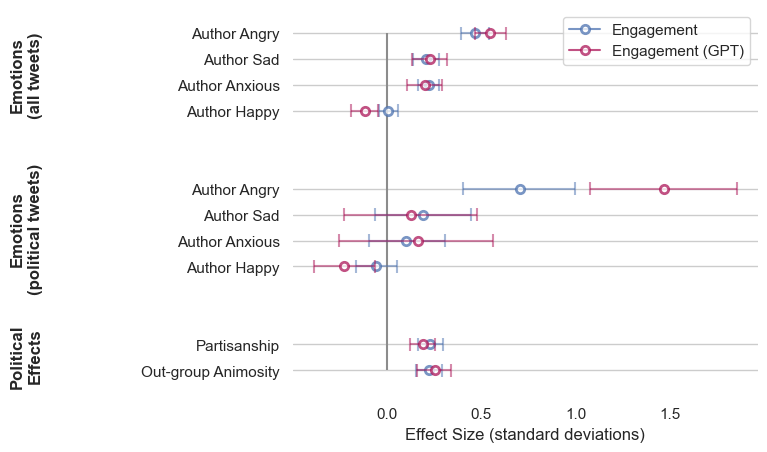

In [9]:
from graph_effects_utils import *

indices = [8, 9, 14, 15, 16, 17, 22, 23, 24, 25]
graph_effects_for_gpt(
    eng_effects=effects, 
    gpt_eng_effects=effects_gpt, 
    effects_indices=indices, 
    save_file='figures/gpt_effects.pdf'
)